# SCTN Resonators

[paper link]()

## The Resonator

< General explanaition what is a resonator >

Using our resonator we can extract frequency from a signal using a SNN.
The output of our resonator is spikes which makes for spiking signal processing applications a perfect match as the feature extraction is part of the network.
The resonator is a small Spiking Network built from 4 neurons and 1 encoding neuron.

Before we dive of how the resonator is built, lets see the output of the resonator!

In [113]:
import numpy as np
from matplotlib import pyplot as plt

from snn.resonator import simple_resonator
from snn.resonator import test_resonator_on_chirp


# todo: move it to utils module
def create_chirp_signal(clk_freq, start_freq, end_freq):
    test_size = clk_freq * (end_freq - start_freq)
    step = 1/clk_freq
    sine_wave = (np.arange(test_size) * step + start_freq + step)
    sine_wave = sine_wave * 2 * np.pi / clk_freq
    sine_wave = np.cumsum(sine_wave)
    return np.sin(sine_wave)

def plot_emitted_spikes(network, x_stop, nid=-1, label=None):
    spikes_neuron = network.neurons[nid]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(y_events[-1] + 1)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(500, dtype=int), 'valid')
    x = np.linspace(0, x_stop, len(y_spikes))
    plt.title('Resonator Output')
    plt.ylabel('Spikes per W500')
    plt.xlabel('Frequency')
    plt.plot(x, y_spikes, label=label)

In [114]:
clk_freq=1536000

resonator = simple_resonator(
        freq0=104,
        clk_freq=clk_freq,
        lf=5,
        thetas=[-1, -5, -5, -5],
        weights=[11, 9, 10, 10, 10],
)

# log the spikes emitted from the last neuron
resonator.log_out_spikes(-1)

spectrum = 200
# To reduce running time.
step = 1/200000
test_size = int(spectrum / step)
test_resonator_on_chirp(
    resonator,
    start_freq=0,
    test_size=test_size,
    clk_freq=clk_freq,
    step=step
)


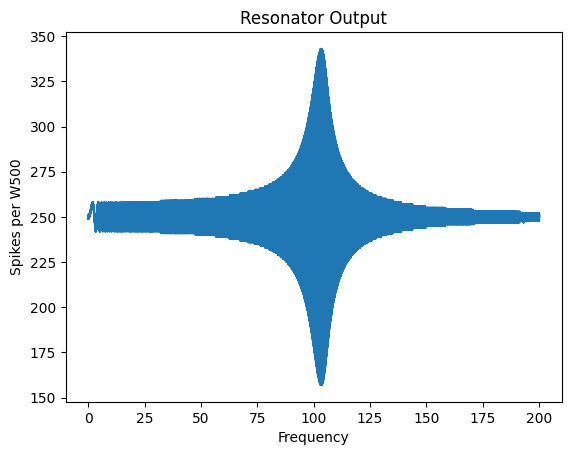

In [115]:
plot_emitted_spikes(resonator, x_stop=spectrum)

What we see in our chart is number of spikes in a window of 500 as function of frequency.
We can see that the number of spikes of the resonator is different near the resonator cutoff frequency and the peak is exactly on the cutoff frequency - f0 (104)

Lets dive in.

### The Input
Our Input for the resonator to show that it works correctly, is using a chirp signal.
Here is an example of signal with changing frequency from 0 to 25

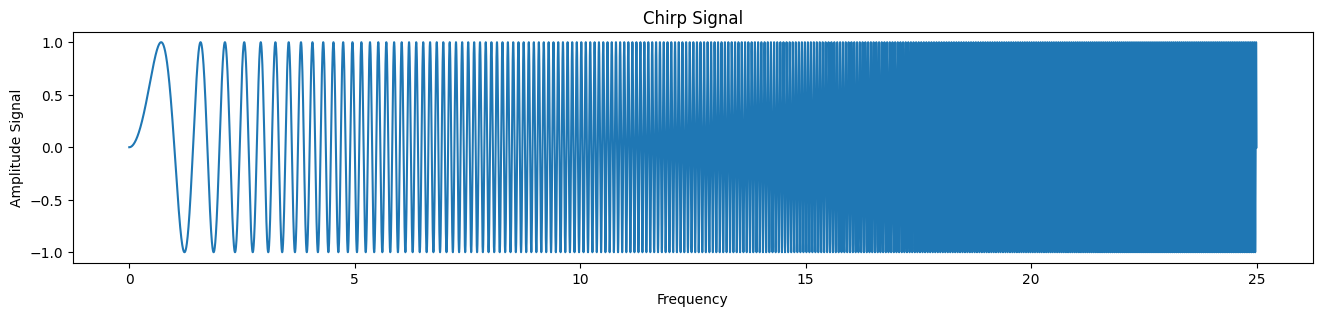

In [116]:
start = 0
stop = 25
clk_freq = 200000
test_size = clk_freq * (stop - start)
step = 1 / clk_freq
chirp = create_chirp_signal(clk_freq, start, stop)
x = np.linspace(start=start, stop=stop, num=test_size)
plt.figure(figsize=(16, 3))  # Width: 10 inches, Height: 6 inches
plt.title('Chirp Signal')
plt.ylabel('Amplitude Signal')
plt.xlabel('Frequency')
plt.plot(x, chirp)

#### The Encoding Neuron
We use PDM encode of the signal to change it from analog to spikes.
We can do it using a SCTN that we control its membrane potential!

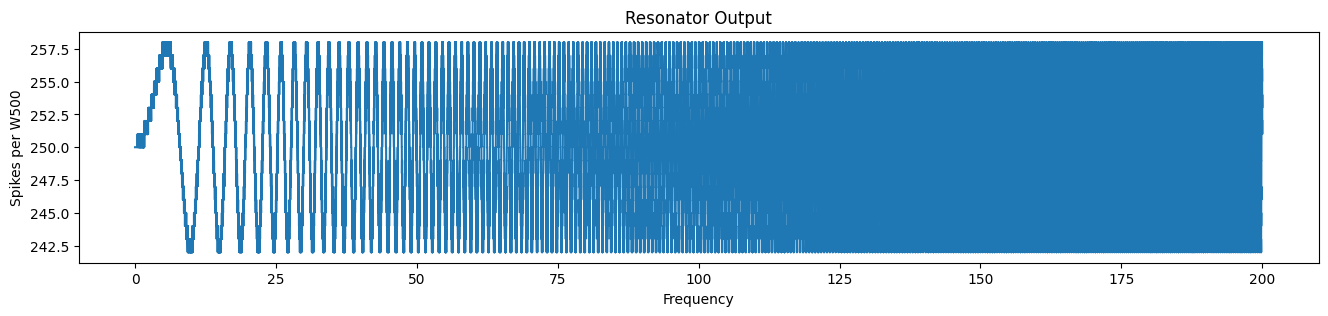

In [117]:
from snn.layers import SCTNLayer
from snn.spiking_neuron import create_SCTN, IDENTITY
from snn.spiking_network import SpikingNetwork

plt.figure(figsize=(16, 3))  # Width: 10 inches, Height: 6 inches
network = SpikingNetwork(1536000)
network.add_amplitude(1000)

# Encode to pdm
neuron = create_SCTN()
neuron.activation_function = IDENTITY
network.add_layer(SCTNLayer([neuron]))
network.log_out_spikes(-1)

network.input_full_data(chirp)
plot_emitted_spikes(network, x_stop=spectrum)

So by setting the membrane potential we can implement a pdm encoder any signal.

### Phase Shift Neuron
Using the SCTN we can take a signal and phase shift it by 45 degrees,
 < Add lf, lp formula for phase shift >

In [118]:
from snn.graphs import plot_network

freq0 = 104
clk_freq = 1536000
LF = 5
LP = 72

Text(0.5, 0, 'Time [s]')

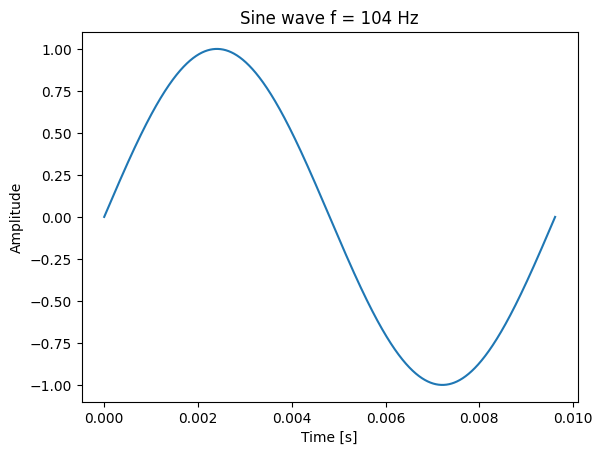

In [119]:
def gen_sine_wave(f, duration, clk_freq, f_cutoff):
    x = np.linspace(0, duration/f_cutoff, int(duration * clk_freq/f_cutoff))
    t = x * 2 * np.pi * f
    sine_wave = np.sin(t)
    return sine_wave, x

sine_wave, x = gen_sine_wave(freq0, duration=1, clk_freq=clk_freq, f_cutoff=freq0)
plt.plot(x, sine_wave)
plt.title('Sine wave f = 104 Hz')
plt.ylabel('Amplitude')
plt.xlabel('Time [s]')

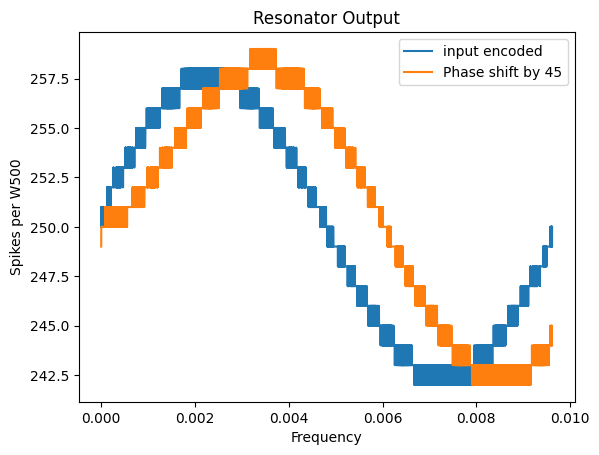

In [120]:
# The Input
network = SpikingNetwork(clk_freq)
network.add_amplitude(1000)

# Encode to pdm
neuron = create_SCTN()
neuron.activation_function = IDENTITY
network.add_layer(SCTNLayer([neuron]))

# Phase shift neuron
neuron = create_SCTN()
neuron.synapses_weights = np.array([10], dtype=np.float64)
neuron.leakage_factor = LF
neuron.leakage_period = LP
neuron.theta = -5
neuron.activation_function = IDENTITY
neuron.membrane_should_reset = False
network.add_layer(SCTNLayer([neuron]))

network.log_out_spikes(0)
network.log_out_spikes(1)

network.input_full_data(sine_wave)
plot_emitted_spikes(network, x_stop=x[-1], nid=0, label='input encoded')
plot_emitted_spikes(network, x_stop=x[-1], nid=1, label='Phase shift by 45')
plt.legend()

So with the right parameters we can phase shift by 45 the signal for the cutoff frequency.
Now lets see what happened for a signal with different frequency.

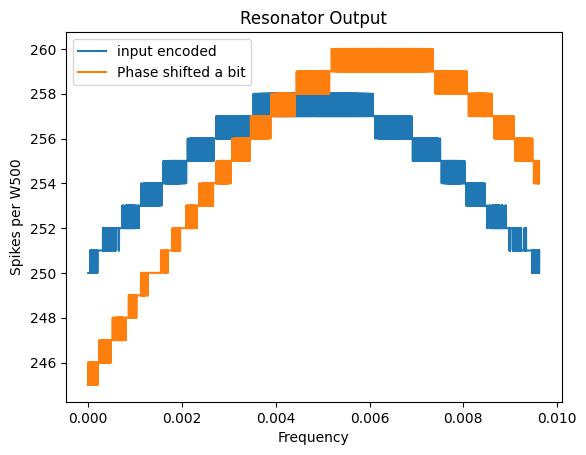

In [121]:
sine_wave, x = gen_sine_wave(freq0/2, 1, clk_freq=clk_freq, f_cutoff=freq0)

network.forget_logs()
network.input_full_data(sine_wave)
plot_emitted_spikes(network, x_stop=x[-1], nid=0, label='input encoded')
plot_emitted_spikes(network, x_stop=x[-1], nid=1, label='Phase shifted a bit')
plt.legend()

Now that we have a neuron that able to move the signal by 45 degrees, we can construct a network that phase shift by 180 degrees for the cutoff frequency!

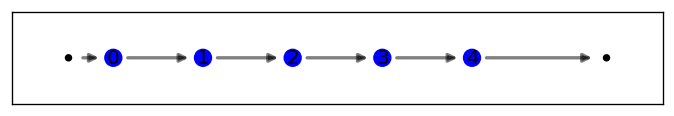

In [122]:
network = SpikingNetwork(clk_freq)
network.add_amplitude(1000)
# Encode to pdm
neuron = create_SCTN()
neuron.activation_function = IDENTITY
network.add_layer(SCTNLayer([neuron]))

# Phase shift neuron by 45
for i in range(4):
    neuron = create_SCTN()
    neuron.synapses_weights = np.array([10], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = -5
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

network.log_out_spikes(0)
network.log_out_spikes(-1)
plot_network(network)

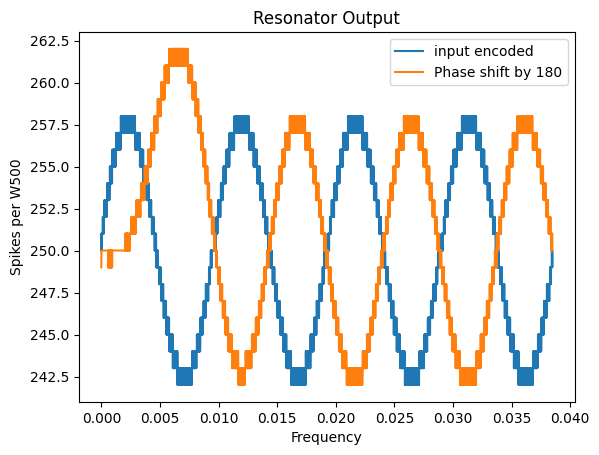

In [123]:
sine_wave, x = gen_sine_wave(freq0, 4, clk_freq=clk_freq, f_cutoff=freq0)

network.input_full_data(sine_wave)
plot_emitted_spikes(network, x_stop=x[-1], nid=0, label='input encoded')
plot_emitted_spikes(network, x_stop=x[-1], nid=-1, label='Phase shift by 180')
plt.legend()

At first the output has some artifacts, but it converges very fast.

Now Lets see what happend for different frequency that is not the cutoff frequency.

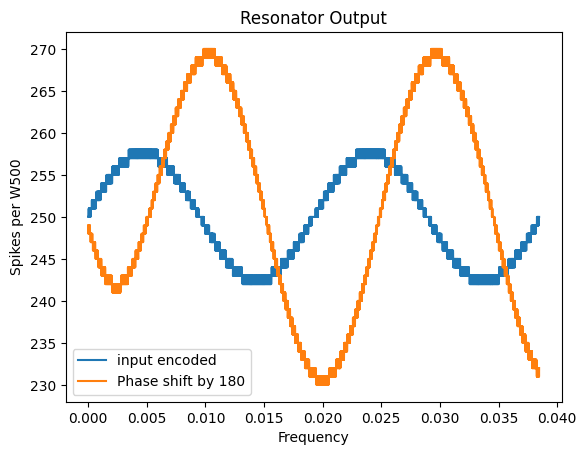

In [124]:
sine_wave, x = gen_sine_wave(freq0/2, 4, clk_freq=clk_freq, f_cutoff=freq0)

network.forget_logs()
network.input_full_data(sine_wave)
plot_emitted_spikes(network, x_stop=x[-1], nid=0, label='input encoded')
plot_emitted_spikes(network, x_stop=x[-1], nid=-1, label='Phase shift by 180')
plt.legend()

So there is no phase shift of 180 for different frequency, now we are ready to construct the resonator.

### The Resonator Structure

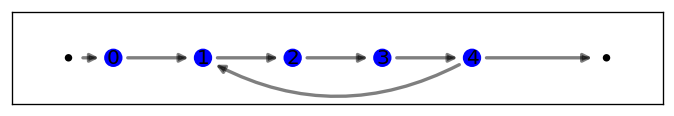

In [125]:
thetas = [-1, -5, -5, -5]
weights = [11, -9, 10, 10, 10]

network = SpikingNetwork(clk_freq)
network.add_amplitude(1000)


# Encode to pdm
neuron = create_SCTN()
neuron.activation_function = IDENTITY
network.add_layer(SCTNLayer([neuron]))

# SCTN 1
neuron = create_SCTN()
neuron.synapses_weights = np.array([weights[0], -weights[1]], dtype=np.float64)
neuron.leakage_factor = LF
neuron.leakage_period = LP
neuron.theta = thetas[0]
neuron.activation_function = IDENTITY
neuron.membrane_should_reset = False
network.add_layer(SCTNLayer([neuron]))

for i in range(3):
    neuron = create_SCTN()
    neuron.synapses_weights = np.array([weights[2+i]], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = thetas[1+i]
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

# feedback
network.connect_by_id(4, 1)

plot_network(network)

Neuron 0 is the pdm encoder and the next 4 neurons is phase shift neuron
The feedback meant to increase the amplitude of the cutoff frequency while it reduce other frequencies.

The same implementation is already in the sctn package using.

In [ ]:
simple_resonator(freq0=104, clk_freq=clk_freq, lf=5, thetas=thetas, weights=weights)
plot_network(network)

As mentioned before the cutoff frequency controlled by `LF` and `LP`, by setting `LF`, `freq0` and `clk_freq`, `LP` is calculated.
but another thing that important to the setting of the resonator is the biases by `thetas` and the `weights`. To control that we use a supervised STDP Learning.
The learning may take few minutes, but we also provide pre-calculated resonators parameters for a lot of frequencies. If you dont find resonator that good enough for your needs, you can learn the weights using the util function:
 <to-do: move the learning process to util function>

In [ ]:
util.fit_resonator(clk_freq, freq0)